In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Various tests on individual functions

## Time Variable s

In [2]:
t = fct.s_of_z(4)
print(type(t), -t)

<class 'numpy.float64'> -7.548019506838111e+17


## Critical Density

In [3]:
crit = fct.rho_crit(0)
print('Check if this matches critical density of universe today:')
print(crit.to(unit.kg/unit.m**3))

Check if this matches critical density of universe today:
8.598814256622896e-27 kg / m3


## Unit Conversion Tests

In [4]:
print(my.T_nu.to(unit.eV, unit.temperature_energy()))

0.00016803799861183098 eV


## Derivative vector values

In [5]:
z = 0
x_i = np.array([8.5,0.,0.])*unit.kpc

t2 = fct.dPsi_dxi_NFW(x_i, z, my.rho0_NFW, my.Mvir_NFW)
print(type(t2), t2)

<class 'astropy.units.quantity.Quantity'> [2.33716425e-29 0.00000000e+00 0.00000000e+00] kpc / s2


# Investigating the shape of the final number density curve

## Relation of p0 to p1

In [6]:
# Amount of simulated neutrinos
Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)

# load initial and final velocity
u0 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[0,3:6] for Nr in Ns]
u1 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[-1,3:6] for Nr in Ns]


# intermediate arrays
a0 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u0)])
a1 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u1)])


# convert mass(es) from eV to kg
m_nu_eV = 0.05 * unit.eV
m_nu_kg = m_nu_eV.to(unit.kg, unit.mass_energy())

p_unit = unit.kg*unit.kpc/unit.s
p0, p1 = a0 * m_nu_kg.value * p_unit, a1 * m_nu_kg.value * p_unit

# convert momenta from kg*kpc/s to eV
to_eV = 1/(5.3442883e-28)
p0 = p0.to(unit.kg*unit.m/unit.s).value * to_eV
p1 = p1.to(unit.kg*unit.m/unit.s).value * to_eV

# they are already sorted
order = p0.argsort()


# plt.plot(p0, p1)

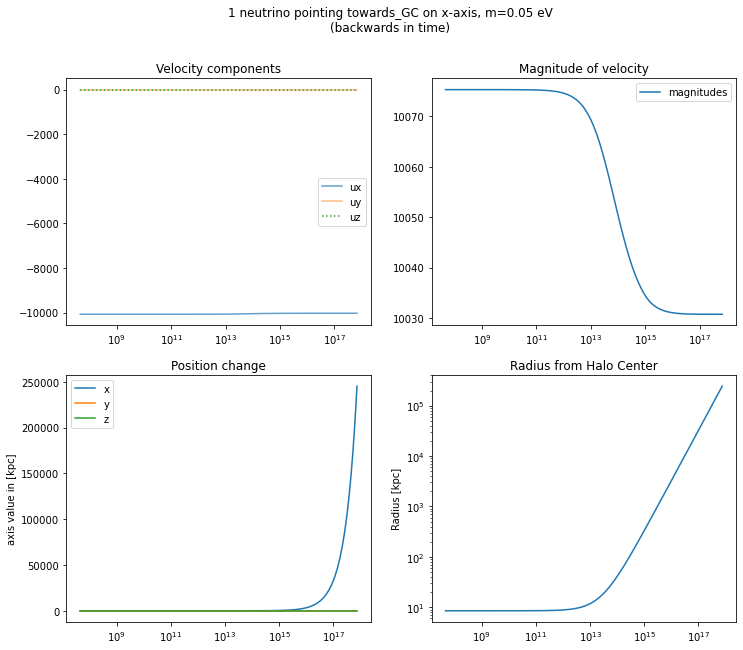

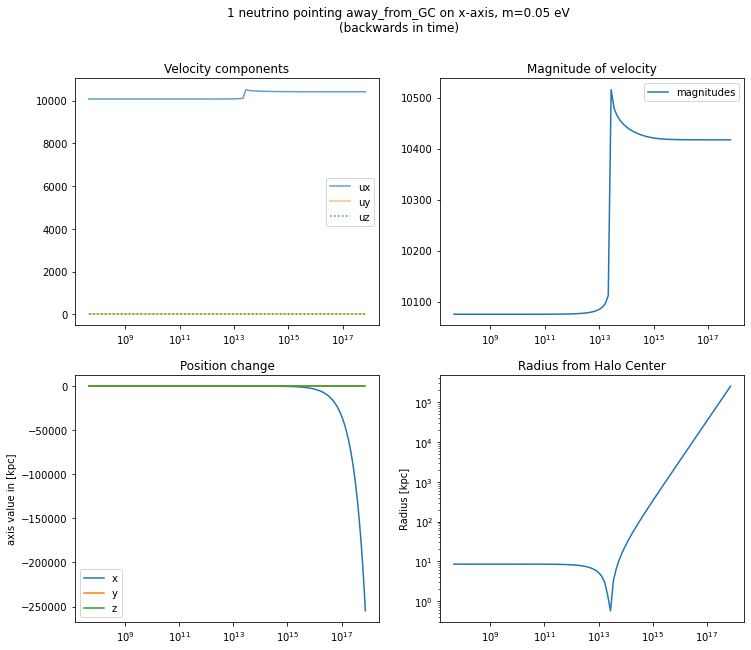

In [7]:
def show_plot(Nr):
    raw = np.load(f'neutrino_vectors/nu_{Nr}.npy')*unit.kpc/unit.s
    u_1nu = raw.to(unit.km/unit.s).value

    #
    ### determine pointing of neutrino relative to GC
    #

    batch_size = CC.THETAs*CC.Vs
    nr_in_array = int(Nr / batch_size)
    ps = np.linspace(0., 2.*np.pi, CC.PHIs)
    val_to_check = ps[nr_in_array]

    direction = 'towards/away'
    if np.pi/2 < val_to_check < 3/2*np.pi:
        direction = 'away_from_GC'
    else:
        direction = 'towards_GC'


    # load velocities
    ux, uy, uz = u_1nu[:,3], u_1nu[:,4], u_1nu[:,5]

    # magnitudes of velocities
    Ms = np.sqrt(ux**2+uy**2+uz**2)

    # range to plot over
    zeds = np.geomspace(1e-10, CC.Z_STOP, CC.Z_AMOUNT)  # log
    H0 = my.H0.to(unit.s**-1).value
    s = np.abs(np.array([fct.s_of_z(z) for z in zeds]) * 1)
    sta = np.argmin(np.abs(zeds-1e-10))
    end = np.argmin(np.abs(zeds-4))
    

    #
    ### Initiate figure
    #

    fig, axs = plt.subplots(2,2, figsize=(12,10))
    
    if CC.TIME_FLOW > 0:
        time_direction = 'forwards'
    else:
        time_direction = 'backwards'
    fig.suptitle(f'1 neutrino pointing {direction} on x-axis, m=0.05 eV'
                 '\n'
                 f'({time_direction} in time)')

    # Plot 1
    axs[0,0].set_title('Velocity components')
    axs[0,0].semilogx(s[sta:end], ux[sta:end], label='ux', alpha=0.7)
    axs[0,0].semilogx(s[sta:end], uy[sta:end], label='uy', alpha=0.5)
    axs[0,0].semilogx(s[sta:end], uz[sta:end], label='uz', ls=':')
    axs[0,0].legend()

    # Plot 2
    axs[0,1].set_title('Magnitude of velocity')
    axs[0,1].semilogx(s[sta:end], Ms[sta:end], label='magnitudes')
    axs[0,1].legend()

    # load positions
    u_1nu = raw.value
    x = u_1nu[:,0]
    y = u_1nu[:,1]
    z = u_1nu[:,2]

    # Plot 3
    axs[1,0].set_title('Position change')
    axs[1,0].set_ylabel('axis value in [kpc]')
    axs[1,0].semilogx(s, x, label='x')
    axs[1,0].semilogx(s, y, label='y')
    axs[1,0].semilogx(s, z, label='z')
    axs[1,0].legend()


    # Plot 4
    radius_from_GC = np.sqrt(x**2+y**2+z**2)
    axs[1,1].set_title('Radius from Halo Center')
    axs[1,1].loglog(s, radius_from_GC, label='radius')
    axs[1,1].set_ylabel('Radius [kpc]')

    plt.savefig(f'check_plots/velocity_and_position_change_{direction}.pdf')


show_plot(Nr=6) # 5 medium velocity, 6 high
show_plot(Nr=24) # 23 medium, 24 high 

## Plot for s and z relation

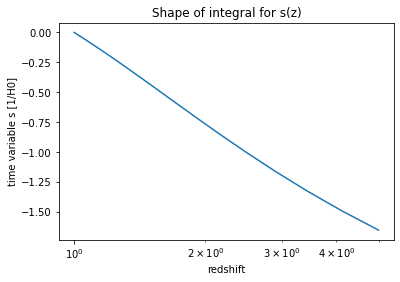

In [8]:
zeds = np.geomspace(1e-10, CC.Z_STOP, CC.Z_AMOUNT)

ss = np.array([fct.s_of_z(z) for z in zeds]) * my.H0.to(unit.s**-1).value


plt.semilogx(1+zeds, -ss)
plt.title('Shape of integral for s(z)')
plt.xlabel('redshift')
plt.ylabel('time variable s [1/H0]')
plt.savefig('check_plots/s_of_z_integral.pdf')

# Distribution plots

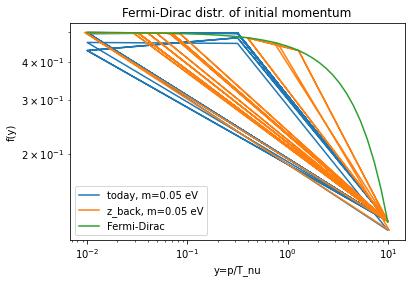

In [9]:
# Original Fermi-Dirac distr.
pOG = np.geomspace(0.01*my.T_nu_eV, 10*my.T_nu_eV, len(p0))
FDvalsOG = fct.Fermi_Dirac(pOG)
yOG = pOG/my.T_nu_eV.value

# Fermi-Dirac distr. of initial momentum (by using p1 momenta at z_back)
y0 = p0/my.T_nu_eV.value
FDvals0 = fct.Fermi_Dirac(p1)

# Fermi-Dirac distr. of final momentum
y1 = p1/my.T_nu_eV.value
FDvals1 = fct.Fermi_Dirac(p1)


plt.loglog(y0, FDvals0, label='today, m=0.05 eV')
plt.loglog(y1, FDvals1, label='z_back, m=0.05 eV')
plt.loglog(yOG, FDvalsOG, label='Fermi-Dirac')
plt.title('Fermi-Dirac distr. of initial momentum')
plt.ylabel('f(y)')
plt.xlabel('y=p/T_nu')
plt.legend(loc='lower left')
plt.savefig('check_plots/fermi_dirac_distr.pdf')

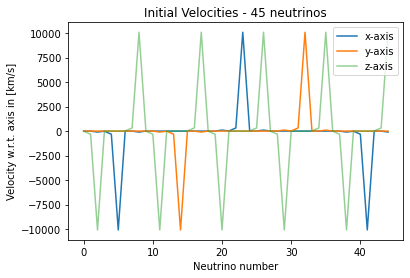

In [10]:
from backtracing import draw_ui

# Draw initial velocities.
ui = draw_ui(CC.PHIs, CC.THETAs, CC.Vs)*my.Uunit
ui = ui.to(unit.km/unit.s).value

ux = ui[:,0]
uy = ui[:,1]
uz = ui[:,2]

x = np.arange(len(ux))
y = np.arange(len(uy))
z = np.arange(len(uz))

plt.plot(x, ux, label='x-axis', )
plt.plot(y, uy, label='y-axis', )
plt.plot(z, uz, label='z-axis', alpha=0.5)
plt.title(f'Initial Velocities - {CC.NR_OF_NEUTRINOS} neutrinos')
plt.xlabel('Neutrino number')
plt.ylabel('Velocity w.r.t. axis in [km/s]')
plt.legend()
plt.savefig('check_plots/initial_velocities.pdf')

In [11]:
x = -np.array([1.,2.])

print(x)

[-1. -2.]
